In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv(r'/kaggle/input/ca-independent-medical-review/Independent_Medical_Review__IMR__Determinations__Trend.csv')
df.sample(n = 3)

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
9836,EI10-11138,2010,Mental,Depression,Electrical/ Thermal/ Radiofreq. Interventions,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,A 56-year-old male enrollee has requested for ...
3596,MN14-19188,2014,Mental,Bipolar Disorder,Mental Health Treatment,Acute Psychiatric Facility Admission,Overturned Decision of Health Plan,Medical Necessity,31-40,Female,A 38-year-old female enrollee requested inpati...
1866,MN15-21044,2015,Mental,Eating Disorder,Mental Health Treatment,Partial Hospitalization,Overturned Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...


In [ ]:
main_df = df[['Findings', 'Determination']]
main_df.sample(3)

,Findings,Determination
2443,Nature of Statutory Criteria/Case Summary: An...,Upheld Decision of Health Plan
9686,A 56-year-old female enrollee has requested DI...,Overturned Decision of Health Plan
12403,A 55-year-old female enrollee has requested fu...,Overturned Decision of Health Plan


In [ ]:
print(f'Number of examples before cleaning = {main_df.shape[0]}')
print(f'Number of examples = {main_df.shape[1]}')

Number of examples before cleaning = 19245
Number of examples = 2


In [ ]:
data_types = main_df.dtypes
data_types

Findings         object
Determination    object
dtype: object

In [ ]:
mask = (main_df.Determination == 'Overturned Decision of Health Plan') # create mask
new_target = mask.astype('int') # change mask to integers
main_df = main_df.assign(Determination = new_target)

In [ ]:
num_missing = main_df.isna().sum()
num_missing

Findings         20
Determination     0
dtype: int64

In [ ]:
main_df = main_df.dropna(axis = 0)
main_df.isna().sum()

Findings         0
Determination    0
dtype: int64

In [ ]:
print(f'Number of examples = {main_df.shape[0]}')
print(f'Number of examples = {main_df.shape[1]}')

Number of examples = 19225
Number of examples = 2


In [ ]:
main_df.head(2)

,Findings,Determination
0,Nature of Statutory Criteria/Case Summary: An ...,1
1,Nature of Statutory Criteria/Case Summary: An...,0


In [ ]:
def plot_training_log(history):
    history = pd.DataFrame(data = history.history, index = history.epoch)
    fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
    ax[0].plot(history.index, history.loss, label = 'Train')
    ax[0].plot(history.index, history.val_loss, label = 'Validation')
    ax[0].set_ylim(0.0,0.5)
    ax[0].set_title('Train_loss vs Val_loss')
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.index, history.accuracy, label = 'Train')
    ax[1].plot(history.index, history.val_accuracy, label = 'Validation')
    ax[1].set_ylim(0.5, 1.0)
    ax[1].set_title('Train_Accuracy vs Val_Accuracy')
    ax[1].legend()
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    plt.show()

def get_predictions(input, label):
    logit = model.predict(input)
    pred = np.squeeze((logit >= 0.0).astype('int'))
    return pred, label

def scheduler(epoch, lr):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [ ]:
Input = main_df['Findings']
output = main_df['Determination']
data_set = tf.data.Dataset.from_tensor_slices((Input,output))

In [ ]:
vocab_size = 1000
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
data_input = data_set.map(lambda x,y: x)
text_vectorizer.adapt(data_input)

In [ ]:
original_text = main_df['Findings'][0][:70]
vocab = np.array(text_vectorizer.get_vocabulary())
text_vectors = text_vectorizer(original_text).numpy()
transcript = ' '.join(vocab[text_vectors])
print(f'Original text: {original_text}')
print('\n')
print(f'tokens: {text_vectors}')
print('\n')
print(f'Transcript: {transcript}')

Original text: Nature of Statutory Criteria/Case Summary: An enrollee has requested H


tokens: [132   3 181 182 164  27  34  12  17   1]


Transcript: nature of statutory criteriacase summary an enrollee has requested [UNK]


In [ ]:
data_set = data_set.batch(64).shuffle(buffer_size = 1000).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_size = 0.8
num_batches = data_set.cardinality().numpy()
num_train = int(num_batches * train_size)
num_val = num_batches - num_train - 1
num_test = 1

train_set = data_set.take(num_train)
train_set_ = data_set.skip(num_train)
val_set = train_set_.take(num_val)
test_set = train_set_.skip(num_val)

# sanity check
print(f'Number of train batches {train_set.cardinality().numpy()}, Number of val batches {val_set.cardinality().numpy()}, Number of test batches {test_set.cardinality().numpy()}')

Number of train batches 240, Number of val batches 60, Number of test batches 1


In [ ]:
model = tf.keras.Sequential([text_vectorizer, tf.keras.layers.Embedding(vocab_size, 64, mask_zero = True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(8, activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
                            ])

RoP = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

print(f'Test accuracy before model training {model.evaluate(test_set)[1]}')

history = model.fit(train_set, epochs=15, validation_data = val_set, callbacks = [RoP])

1/1 [==============================] - 7s 7s/step - loss: 0.6929 - accuracy: 0.4531
Test accuracy before model training 0.453125
Epoch 1/15
240/240 [==============================] - 128s 495ms/step - loss: 0.5348 - accuracy: 0.7392 - val_loss: 0.2786 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 2/15
240/240 [==============================] - 119s 496ms/step - loss: 0.3405 - accuracy: 0.9135 - val_loss: 0.2418 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 3/15
240/240 [==============================] - 120s 498ms/step - loss: 0.3344 - accuracy: 0.8929 - val_loss: 0.2142 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 4/15
240/240 [==============================] - 120s 499ms/step - loss: 0.2176 - accuracy: 0.9353 - val_loss: 0.2096 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 5/15
240/240 [==============================] - 119s 495ms/step - loss: 0.2000 - accuracy: 0.9415 - val_loss: 0.2035 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 6/15
240/240 [==============================] - 119s 491ms/step - loss

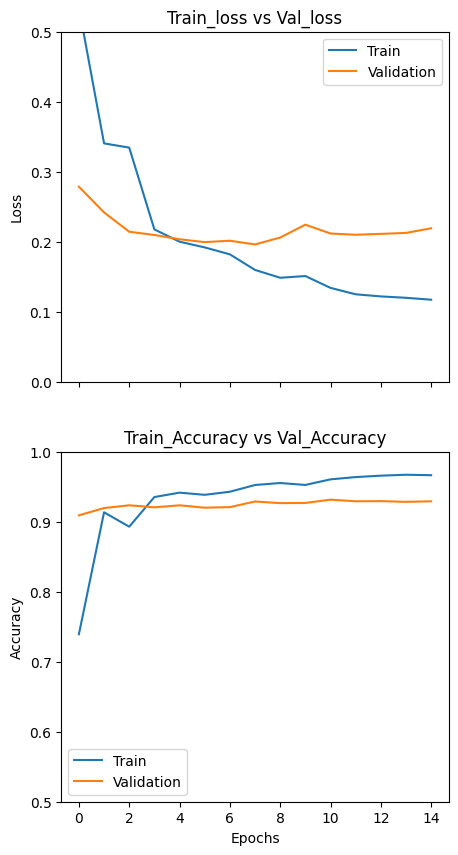

In [ ]:
plot_training_log(history)

In [ ]:
print(f'Test accuracy after model training {model.evaluate(test_set)[1]}')

1/1 [==============================] - 0s 159ms/step - loss: 0.0047 - accuracy: 1.0000
Test accuracy after model training 1.0


In [ ]:
random_idx = np.random.choice(main_df.shape[0])
sample_input = main_df[['Findings']].values[random_idx]
sample_output = main_df['Determination'].values[random_idx]

v, n = get_predictions(sample_input, sample_output)
print(f'Predicted output is {v} and True label is {n}')

1/1 [==============================] - 2s 2s/step
Predicted output is 1 and True label is 1
